## Global Imports

In [ ]:
import pandas
import seaborn as sn
import os
import missingno as msno
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing
import numpy as np
%matplotlib inline

## Reading London Real Estate Data Till 2014

In [ ]:
data = pandas.read_csv("/home/vivek/Documents/mydata/iimb/london_data_complete.csv")

## Missing Value Analysis

In [ ]:
msno.matrix(data)
msno.bar(data)

In [ ]:
print (len(data["borough_code"].unique()))
print (len(data["ward_code"].unique()))

## Filtering Required Columns 

In [ ]:
#colSel = ["id","price","date_processed","post_code","property_type","whether_new","tenure",\
#          "town","local_authority","inner_outer","borough_code","ward_code","year","month","year_month"]
clusterColSel = ["post_code","price","borough_code"]
dataFiltered = data[clusterColSel]
dataFiltered.shape
del data

## DataType Count

In [ ]:
dataTypeDf = pandas.DataFrame(dataFiltered.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

## Filtering And Dummfying Original Data

In [ ]:
for c in dataFiltered.columns:
    print (c)
    if dataFiltered[c].dtype == 'object' and c not in ["post_code","date_processed","id"] :
        # encoding in dummy variable
        dummies = pandas.get_dummies(dataFiltered[c],prefix=c).astype(np.int8)
        dataFiltered = pandas.concat([dataFiltered,dummies],axis=1)

        # removing the Dummified Variable
        dataFiltered.drop(c,axis=1,inplace=True)

## Preparing Data For Clustering 

In [ ]:
def df_subset(df,yearCount,colName,measureType):
    yearValue = 2012-yearCount
    dfSubset = df[df["year"]>yearValue]
    calValues = dataFiltered.groupby(by=["post_code"])[colName].agg(measureType).tolist()
    return colValues

## Creating Price Columns

In [ ]:
clusDataFrame = pandas.DataFrame(dataFiltered.groupby(["post_code"])["price"].mean()).reset_index()
clusDataFrame["medianPrice"] = dataFiltered.groupby(by=["post_code"])["price"].median().tolist()
clusDataFrame["maxPrice"] = dataFiltered.groupby(by=["post_code"])["price"].max().tolist()
clusDataFrame["minPrice"] = dataFiltered.groupby(by=["post_code"])["price"].min().tolist()

## Joining Borough Information

In [ ]:
clusBoroughAdded = clusDataFrame.merge(boroughData,how="left",on="post_code")
dummies = pandas.get_dummies(clusBoroughAdded["borough_code"],prefix="borough_").astype(np.int8)
clusBoroughDummified = pandas.concat([clusBoroughAdded,dummies],axis=1)

# removing the Dummified Variable
clusBoroughDummified.drop("borough_code",axis=1,inplace=True)

## Joining Google Places Information

In [ ]:
googlePlaces = pandas.read_csv("/home/vivek/Documents/mydata/iimb/google_places_details//google_places_complete.csv")
googlePlaces.head(2)

In [ ]:
finalClusterData = clusBoroughDummified.merge(googlePlaces,how="left",on="post_code")
finalClusterData.to_csv("/home/vivek/Documents/mydata/iimb/clustering_dataset.csv",index=False)

## K Means Clustering

In [52]:
clusDataOriginal = pandas.read_csv("/home/vivek/Documents/mydata/iimb/clustering_dataset.csv",skiprows=[1])
clusData = clusDataOriginal.drop(["post_code"],axis=1)

In [ ]:
clusData.select_dtypes(include=["int64"]).columns

In [85]:
standardCols = []
boroughCols = []
for col in clusData.columns:
    if "borough" not in col and col not in ["latitude","longitude"]:
        standardCols.append(col)
    else:
        boroughCols.append(col) 
priceCols = ['price','medianPrice','maxPrice','minPrice']

In [88]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_non_borough_matrix = scaler.fit_transform( clusData[priceCols])

In [87]:
X_borough_matrix = clusData[boroughCols].as_matrix()
finalClusMatrix = np.concatenate((X_non_borough_matrix,X_borough_matrix),axis=1)

In [89]:
import time
start_time = time.time()
cluster_range = list(range( 1,15,1))
cluster_errors = []
startTime = time.localtime

for num_clusters in cluster_range:
    print ("current num of clusters: ",num_clusters)
    clusters = KMeans( num_clusters )
    clusters.fit( X_non_borough_matrix )
    cluster_errors.append( clusters.inertia_ )
    print("Time Take For Given Run %s seconds" % (time.time() - start_time))
    print ("#################################")
    
print("Total Time Taken Is %s seconds" % (time.time() - start_time))

current num of clusters:  1
Time Take For Given Run 0.848240852355957 seconds
#################################
current num of clusters:  2
Time Take For Given Run 2.484393835067749 seconds
#################################
current num of clusters:  3
Time Take For Given Run 4.383542537689209 seconds
#################################
current num of clusters:  4
Time Take For Given Run 6.990019798278809 seconds
#################################
current num of clusters:  5
Time Take For Given Run 9.582504749298096 seconds
#################################
current num of clusters:  6
Time Take For Given Run 12.8417489528656 seconds
#################################
current num of clusters:  7
Time Take For Given Run 17.9674334526062 seconds
#################################
current num of clusters:  8
Time Take For Given Run 22.486526250839233 seconds
#################################
current num of clusters:  9
Time Take For Given Run 28.342963218688965 seconds
##########################

In [90]:
clusters_df = pandas.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

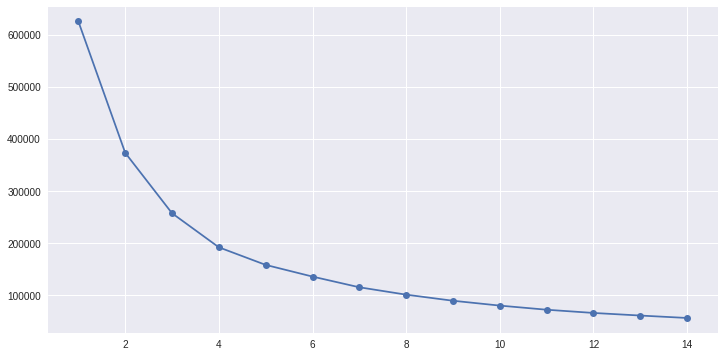

In [91]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

## Clustering With No Of Cluster As 4

In [92]:
clusters = KMeans( 4 )
clusters.fit( X_non_borough_matrix )

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [95]:
clusData["cluster"]  = clusters.labels_

In [115]:
clusData["cluster"].value_counts()

0    140528
3     14254
1      1402
2        86
Name: cluster, dtype: int64

In [104]:
import folium
default = (51.5155,-0.0922)
map = folium.Map(location=default, zoom_start=10)
cmark_map = folium.Map(location=default, zoom_start=10,tiles='Stamen Terrain')
toner_map = folium.Map(location=default, zoom_start=10,tiles='Stamen Toner')

In [105]:
colorCodes = {0:"red",1:"blue",2:"green",3:"orange", 4:"yellow",5:"black",6:"brown",
              7:"pink",8:"grey",9:"white",10:"purple"}

In [141]:
sample = pandas.DataFrame(clusData.groupby('cluster').apply(lambda x: x.sample(frac=.1)))
sample.shape

(15627, 57)

In [142]:
cmark_map2 = folium.Map(location=default, zoom_start=10,tiles='Stamen Terrain')
for each in sample.iterrows():
    #print (each)
    folium.CircleMarker(radius=7, color=colorCodes[each[1]["cluster"]],fill_color=colorCodes[each[1]["cluster"]],location=[each[1]['latitude'], each[1]['longitude']]).add_to(cmark_map2)

In [143]:
cmark_map2

In [144]:
map.save("/home/vivek/Documents/mydata/iimb/cluster_output.html")